In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
pip install bootstrapped

In [4]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

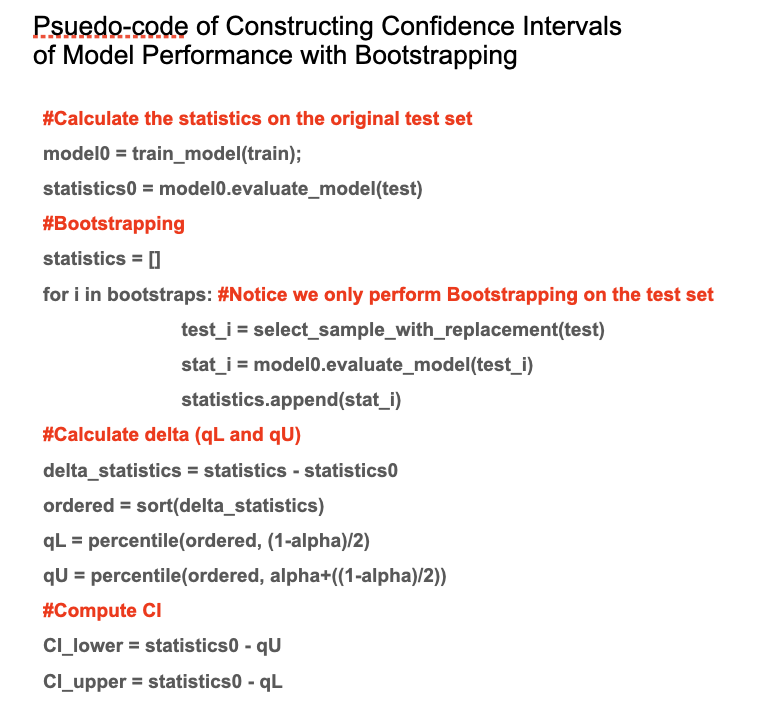

# 1. Boostrap basics

In [241]:
np.random.seed(30) 
normal_data = np.random.normal(4, 1.5, 50) #mean 4, std 1.5, number of samples 50

To the best of the GSIs' knowledge, there is no perfect package for boostrap validation in `Python`. Therefore, the function below is a simple manual implementation of the bootstrap. Note that there is nothing tricky in the code below and you are encouraged to try the implementation on your own. It is actually a required exercise for statistics majors.

For `R` users, a package that is widely used for bootstrapping in `R` is `boot`. 

In [244]:
def bootstrap(data, metrics,sample =500, random_state=123):
    output_array=np.zeros(sample)
    output_array[:]=np.nan
    for i in range(sample):
        bs_data = np.random.choice(data, len(data), replace=True)
        output_array[i] = metrics(bs_data)
    return output_array

In [246]:
boot_out = bootstrap(normal_data, np.mean)

(array([ 2.,  1.,  2.,  2.,  4.,  3.,  4.,  9., 11., 21., 24., 31., 33.,
        33., 48., 37., 41., 23., 33., 37., 25., 19., 24.,  8.,  7.,  6.,
         5.,  2.,  3.,  2.]),
 array([3.13035618, 3.17761647, 3.22487676, 3.27213705, 3.31939734,
        3.36665763, 3.41391793, 3.46117822, 3.50843851, 3.5556988 ,
        3.60295909, 3.65021938, 3.69747967, 3.74473996, 3.79200025,
        3.83926055, 3.88652084, 3.93378113, 3.98104142, 4.02830171,
        4.075562  , 4.12282229, 4.17008258, 4.21734287, 4.26460316,
        4.31186346, 4.35912375, 4.40638404, 4.45364433, 4.50090462,
        4.54816491]),
 <BarContainer object of 30 artists>)

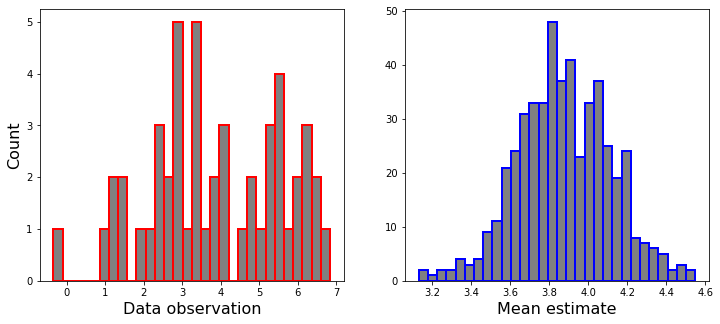

In [255]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
axs[0].set_xlabel('Data observation', fontsize=16)
axs[1].set_xlabel('Mean estimate', fontsize=16)
axs[0].set_ylabel('Count', fontsize=16)
axs[0].hist(normal_data,bins=30,edgecolor='red', linewidth=2,color = "grey")
axs[1].hist(boot_out,bins=30,edgecolor='blue', linewidth=2,color = "grey")

Using the bootstrap output, you can compute the stiatistics (e.g., mean, standard deviation, quantiles) of the boostrap estimates.

In [260]:
print("mean of the estimate %.2f" % np.mean(boot_out))
print("sd of the estimate: %.2f " % np.std(boot_out))
print("0.025-quantile of the estimate: %.2f " % np.quantile(boot_out, 0.025))
print("0.975-quantile of the estimate: %.2f " % np.quantile(boot_out, 0.975))

mean of the estimate 3.88
sd of the estimate: 0.24 
0.025-quantile of the estimate: 3.40 
0.975-quantile of the estimate: 4.36 


## 2. Bootstrap for Model Validation 

### 2.1 Preliminaries

#### 2.1.1 From Lab 7

In [65]:
ctr = pd.read_csv("CTR.csv")

from sklearn.model_selection import train_test_split

y = ctr['CTR']
X = pd.get_dummies(ctr.drop(['CTR'], axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)
X_train.shape, X_test.shape

((4239, 18), (1818, 18))

In [64]:
def OSR2(model, X_test, y_test, y_train):
    
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)

Note that we take the random forest model as an example; However, bootstrap for valiation can be applied to any trained model.

Below, we train the random forest model, on the training data and with the best parameters found through cross-validation in Lab 7.

In [66]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=11, min_samples_leaf=5, 
                           n_estimators = 500, random_state=88, verbose=1)
# Note: you can change the verbose parameter to control how much training progress is printed.
rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.8s finished


RandomForestRegressor(max_features=11, min_samples_leaf=5, n_estimators=500,
                      random_state=88, verbose=1)

In [68]:
rf.verbose = False
print('OSR2:', round(OSR2(rf, X_test, y_test, y_train), 5))

OSR2: 0.56398


#### 2.1.2 Define metrics functions

In [149]:
def OS_R_squared(predictions, y_test,y_train):
    SSE = np.sum((y_test-predictions)**2)
    SST = np.sum((y_test-np.mean(y_train))**2)
    r2 = 1-SSE/SST
    return r2

def mean_squared_error(predictions, y_test,y_train):
    MSE = np.mean((y_test-predictions)**2)
    return MSE

def mean_absolute_error(predictions, y_test,y_train):
    MAE = np.mean(np.abs(y_test-predictions))
    return MAE

#### 2.1.3 Sanity check

In [155]:
y_pred = rf.predict(X_test)
print("OSR2: %s" % OS_R_squared(y_pred,y_test,y_train))
print("MSE: %s" % mean_squared_error(y_pred,y_test,y_train))
print("MAE: %s" % mean_absolute_error(y_pred,y_test,y_train))

OSR2: 0.5639762833152002
MSE: 0.0023534658642130326
MAE: 0.0291244008514368


In [156]:
#different ways to calculate the above metrics

print("OSR2: %s" % OSR2(rf, X_test, y_test,y_train))
print("MSE: %s" % np.mean((y_pred-y_test)**2))
print("MAE: %s" % np.mean(np.abs(y_pred-y_test)))

OSR2: 0.5639762833152002
MSE: 0.0023534658642130326
MAE: 0.0291244008514368


### 2.2 Boostrapping

#### 2.2.1 Manually code the bootstrap method

Again, below is a manual implementation of bootstrap for model valiation.

In [251]:
import time

def bootstrap_validation(test_data, test_label, train_label, model, metrics_list, sample=500, random_state=66):
    tic = time.time()
    n_sample = sample
    n_metrics = len(metrics_list)
    output_array=np.zeros([n_sample, n_metrics])
    output_array[:]=np.nan
    print(output_array.shape)
    for bs_iter in range(n_sample):
        bs_index = np.random.choice(test_data.index, len(test_data.index), replace=True)
        bs_data = test_data.loc[bs_index]
        bs_label = test_label.loc[bs_index]
        bs_predicted = model.predict(bs_data)
        for metrics_iter in range(n_metrics):
            metrics = metrics_list[metrics_iter]
            output_array[bs_iter, metrics_iter]=metrics(bs_predicted,bs_label,train_label)
#         if bs_iter % 100 == 0:
#             print(bs_iter, time.time()-tic)
    output_df = pd.DataFrame(output_array)
    return output_df

#### 2.2.2 Do bootstrap

Note that here we use B = 5,000, instead of 10,000 as shown in the lecutre. Later, you will observe in the histogram that with this resampling size, the estimates of the metrics have already displayed the nice normal curve shape.

The following code takes about 10 minutes to run. You might want to reduce the value of B for a trial run. However, B should not be too small; otherwise, the estimates may not converge to the standard normal distribution well.

In [252]:
bs_output = bootstrap_validation(X_test,y_test,y_train,rf,
                                 metrics_list=[OS_R_squared, mean_squared_error,mean_absolute_error],
                                 sample = 5000)

(5000, 3)
0 0.16818022727966309
100 12.173871040344238
200 23.862328052520752
300 35.761780977249146
400 47.6622519493103
500 59.43642020225525
600 71.27170920372009
700 83.22230005264282
800 97.51952624320984
900 110.55473518371582
1000 123.39684820175171
1100 136.24608993530273
1200 148.26558423042297
1300 160.95892119407654
1400 173.37420010566711
1500 185.55910110473633
1600 198.01273918151855
1700 210.37250804901123
1800 223.2964689731598
1900 235.56481409072876
2000 247.83400797843933
2100 259.7914879322052
2200 272.01751708984375
2300 283.8240759372711
2400 295.65291118621826
2500 307.5280930995941
2600 319.78182315826416
2700 331.8175871372223
2800 344.04978013038635
2900 356.2299382686615
3000 368.17977118492126
3100 380.4845862388611
3200 392.7604970932007
3300 404.9699990749359
3400 416.9263231754303
3500 428.88127994537354
3600 440.8843231201172
3700 452.65862011909485
3800 464.27963614463806
3900 476.1426842212677
4000 488.05449533462524
4100 499.7994170188904
4200 511.984

### 2.3 Visualization

#### 2.3.1 Basic plot and centered plot

(-0.15, 0.15)

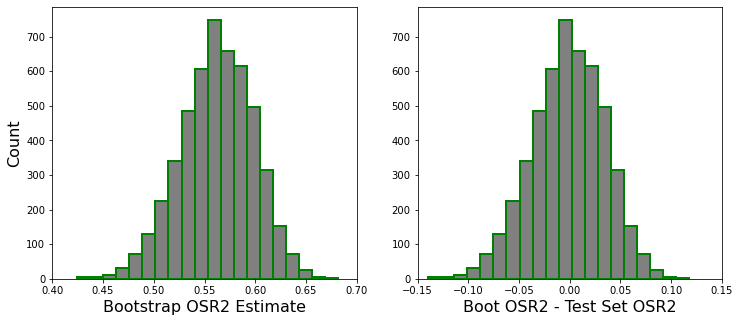

In [240]:
test_OSR2 = OS_R_squared(y_pred,y_test,y_train)

fig, axs = plt.subplots(ncols=2, figsize=(12,5))
axs[0].set_xlabel('Bootstrap OSR2 Estimate', fontsize=16)
axs[1].set_xlabel('Boot OSR2 - Test Set OSR2', fontsize=16)
axs[0].set_ylabel('Count', fontsize=16)
axs[0].hist(bs_output.iloc[:,0], bins=20,edgecolor='green', linewidth=2,color = "grey")
axs[0].set_xlim([0.4,0.7])
axs[1].hist(bs_output.iloc[:,0]-test_OSR2, bins=20,edgecolor='green', linewidth=2,color = "grey")
axs[1].set_xlim([-0.15,0.15])

#### 2.3.2 manual CI + plot

In [248]:
# The 95% confidence interval
CI_0 = np.quantile(bs_output.iloc[:,0]-test_OSR2,np.array([0.025,0.975]))
CI[0] = test_OSR2 - CI_0[1]
CI[1] = test_OSR2 - CI_0[0]
print("The 95-percent confidence interval of OSR2 is %s" % CI) #0.5,0.64

The 95-percent confidence interval of OSR2 is [-0.07548387  0.06474156]


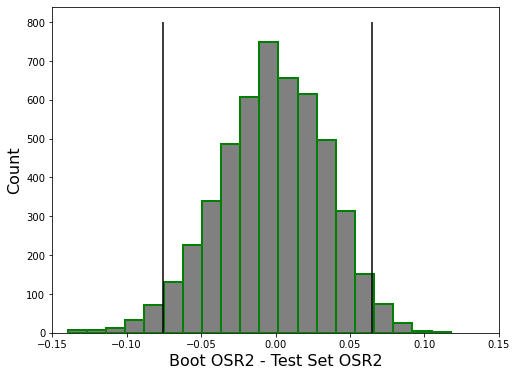

In [250]:
fig, axs = plt.subplots(ncols=1, figsize=(8,6))
axs.set_xlabel('Boot OSR2 - Test Set OSR2', fontsize=16)
axs.set_ylabel('Count', fontsize=16)
axs.hist(bs_output.iloc[:,0]-test_OSR2, bins=20,edgecolor='green', linewidth=2,color = "grey")
axs.set_xlim([-0.15,0.15])
axs.vlines(x=CI[0], ymin = 0, ymax =800, color = "black")
axs.vlines(x=CI[1], ymin = 0, ymax =800, color = "black")